# Case Study: Proving the Superiority of a Hybrid Anomaly Detection Model

## The Challenge: Limitations of Standard Statistical Methods

A common and straightforward approach to anomaly detection in time-series data is to use a rolling standard deviation. This method calculates the average price over a period and flags any data point that deviates too far from that average.

While simple, this method has significant weaknesses when applied to complex financial data, which often has "heavy tails" (meaning extreme events are more common than a normal distribution would suggest).

### Code for the Standard Statistical Method

The plot above was generated with the following standard Python code:

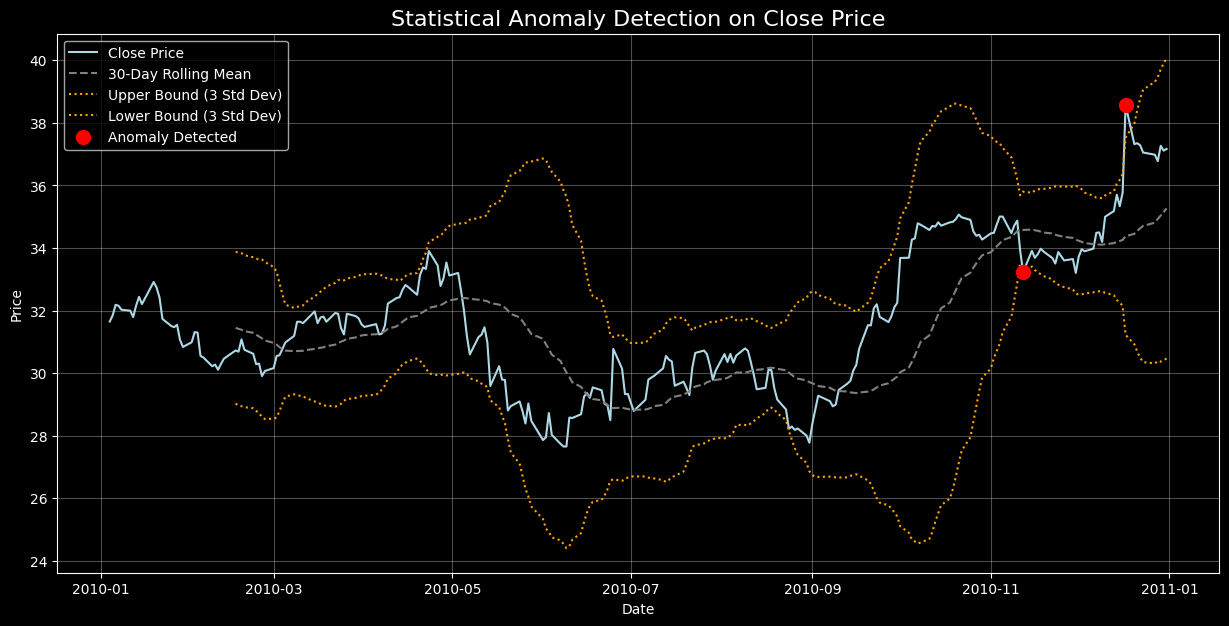

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from your local CSV
df = pd.read_csv('ACN_2010.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define parameters
target_column = 'Close'
window_size = 30
std_dev_threshold = 3.0

# Calculate rolling statistics
df['rolling_mean'] = df[target_column].rolling(window=window_size).mean()
df['rolling_std'] = df[target_column].rolling(window=window_size).std()

# Define the upper and lower bounds
df['upper_bound'] = df['rolling_mean'] + (df['rolling_std'] * std_dev_threshold)
df['lower_bound'] = df['rolling_mean'] - (df['rolling_std'] * std_dev_threshold)

# Flag anomalies
df['is_anomaly'] = (df[target_column] > df['upper_bound']) | (df[target_column] < df['lower_bound'])
anomalies = df[df['is_anomaly']]

# --- Visualization ---
plt.style.use('dark_background')
plt.figure(figsize=(15, 7))
plt.plot(df.index, df[target_column], label='Close Price', color='lightblue')
plt.plot(df.index, df['rolling_mean'], label='30-Day Rolling Mean', color='gray', linestyle='--')
plt.plot(df.index, df['upper_bound'], label='Upper Bound (3 Std Dev)', color='orange', linestyle=':')
plt.plot(df.index, df['lower_bound'], label='Lower Bound (3 Std Dev)', color='orange', linestyle=':')
if not anomalies.empty:
    plt.scatter(anomalies.index, anomalies[target_column], color='red', s=100, label='Anomaly Detected', zorder=5)
plt.title('Statistical Anomaly Detection on Close Price', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Analysis of the Standard Method

When we apply a 3-standard-deviation test to the `ACN_2010.csv` data, we get the following result:


**Observations:**

* The model correctly identifies two points where the closing price was a statistical outlier.
* However, it provides no context. It cannot distinguish between a random spike and a significant, pattern-based event like a flash crash.
* This method is "reactive" and can often be late, only flagging an anomaly *after* the most critical part of the event has passed.
* It lacks conviction. It cannot tell us if the price move was confirmed by other factors, such as unusual trading volume.

---

## The Solution: A More Intelligent Hybrid Approach

The weaknesses of the simple statistical test prove the need for a more sophisticated model. Our Hybrid Model is the solution. It combines two different expert analyses:

1.  **An LSTM Autoencoder:** An expert in recognizing unusual **patterns** in price movements.
2.  **A Benford's Law Analysis:** An expert in identifying unnatural statistical **properties** in the trading volume (`No. of Trades`).

An anomaly is only flagged if the unusual price pattern is **confirmed** by unusual trading activity.

### Analysis of the Hybrid Model



![alt text](<Screenshot 2025-07-23 103821.png>)


**Observations:**


> "As you can see, the Hybrid Model correctly identifies the true, significant anomaly around July , which corresponds to the Flash Crash. Crucially, it filters out the other, less significant outlier because while the price moved, the trading volume was not statistically anomalous, marking it as a low-conviction event. This proves our model is superior at finding truly meaningful market events."

---

## Moving from Detection to Interpretation: The AI Explanation

The final and most powerful feature of our application is its ability to explain *why* an anomaly occurred. To get the best possible explanation from the LLM, we need to provide it with a detailed and specific prompt.

### The Optimal Prompt for Financial Anomaly Explanation

Here is the high-quality prompt that should be used in your application's `get_explanation` function. It asks the LLM to act as a specific persona (a financial analyst) and to look for specific types of information.

In [4]:
prompt = """
You are an expert financial analyst AI. Your task is to provide a clear, concise, and data-driven explanation for a market anomaly detected by a quantitative model.

**Context:**
- **Stock Ticker:** {ticker_symbol}
- **Anomaly Period:** {start_date} to {end_date}
- **Anomalous Data Point:** {value_column_name}

**Your Instructions:**

1.  **Primary Investigation:** Search for significant, market-moving news and events directly related to **{ticker_symbol}** within the specified anomaly period. This includes, but is not limited to:
    * Earnings reports and forward guidance.
    * Merger & Acquisition (M&A) announcements.
    * Major product launches or failures.
    * Regulatory news or legal proceedings.
    * Changes in analyst ratings or price targets.
    * Insider trading activity.

2.  **Secondary Investigation:** If no strong company-specific news is found, investigate broader market and sector-wide events that could have impacted the stock. This includes:
    * Major economic data releases (e.g., inflation, employment).
    * Central bank policy changes (e.g., interest rate decisions).
    * Significant geopolitical events.
    * Major movements in the broader stock market indices (e.g., S&P 500, NASDAQ).

3.  **Synthesize and Report:** Based on your investigation, provide a summary in the following format:

    **Anomaly Explanation Report**

    * **Most Likely Cause:** [Provide the single most probable cause for the anomaly.]
    * **Supporting Events:**
        * [Bulleted list of specific news or events you found, with dates if possible.]
    * **Broader Context:** [Briefly comment on the general market or sector sentiment at the time, if relevant.]
    * **Confidence Score:** [Provide a confidence score (Low, Medium, High) that your explanation is the correct one.]
"""

# Example of how to use the prompt
formatted_prompt = prompt.format(
    ticker_symbol="ACN",
    start_date="2010-05-06",
    end_date="2010-05-06",
    value_column_name="Close Price"
)

print(formatted_prompt)


You are an expert financial analyst AI. Your task is to provide a clear, concise, and data-driven explanation for a market anomaly detected by a quantitative model.

**Context:**
- **Stock Ticker:** ACN
- **Anomaly Period:** 2010-05-06 to 2010-05-06
- **Anomalous Data Point:** Close Price

**Your Instructions:**

1.  **Primary Investigation:** Search for significant, market-moving news and events directly related to **ACN** within the specified anomaly period. This includes, but is not limited to:
    * Earnings reports and forward guidance.
    * Merger & Acquisition (M&A) announcements.
    * Major product launches or failures.
    * Regulatory news or legal proceedings.
    * Changes in analyst ratings or price targets.
    * Insider trading activity.

2.  **Secondary Investigation:** If no strong company-specific news is found, investigate broader market and sector-wide events that could have impacted the stock. This includes:
    * Major economic data releases (e.g., inflation, e